# Simple autoencoder

This is a very simple autoencoder based on a MLP architecture.

In [1]:
import os
import sys

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets, transforms
from torchsummary import summary
from torchvision.utils import save_image

In [2]:
if not os.path.exists('./simple_autoencoder'):
    os.mkdir('./simple_autoencoder')

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [3]:
input_size= (1,784,)
num_epochs = 10
batch_size = 128
learning_rate = 1e-3

dataloader = torch.utils.data.DataLoader(
        datasets.MNIST('../../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)

In [4]:
imgs,labels= next(iter(dataloader))

In [5]:
class autoencoder(nn.Module):
    def __init__(self, width=13):
        super(autoencoder, self).__init__()
        self.width = width
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, self.width) )
            
        self.decoder = nn.Sequential(
            nn.Linear(self.width, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x 
      
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,code):
        return self.decoder(code)

In [6]:
width=13
model = autoencoder(width=width)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [7]:
summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]         100,480
              ReLU-2               [-1, 1, 128]               0
            Linear-3                [-1, 1, 64]           8,256
              ReLU-4                [-1, 1, 64]               0
            Linear-5                [-1, 1, 13]             845
            Linear-6                [-1, 1, 64]             896
              ReLU-7                [-1, 1, 64]               0
            Linear-8               [-1, 1, 128]           8,320
              ReLU-9               [-1, 1, 128]               0
           Linear-10               [-1, 1, 784]         101,136
             Tanh-11               [-1, 1, 784]               0
Total params: 219,933
Trainable params: 219,933
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [9]:
Loss = []
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        
        output = model(img)
        loss = criterion(output, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    Loss.append(loss.item())
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        pic = to_img(output.data)
        save_image(pic, './simple_autoencoder/image_{}_width_{}.png'.format(epoch,width))

In [10]:
torch.save(model.state_dict(), './simple_autoencoder/simple_autoencoder_' + str(width) + '.pt')

In [11]:
from matplotlib import pyplot as plt
plt.plot(Loss,'-bo')
plt.show()

<Figure size 640x480 with 1 Axes>

In [12]:
model.load_state_dict(torch.load('./simple_autoencoder/simple_autoencoder_' + str(width) + '.pt'))
model.eval()

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=13, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [13]:
imgs,labels= next(iter(dataloader))
print(labels[:10])

tensor([9, 8, 2, 3, 5, 6, 7, 7, 6, 7])


In [14]:
first = 2
second = 5
a = model.encode(imgs[first].flatten()).detach().numpy()
b = model.encode(imgs[second].flatten()).detach().numpy()
print(a,b)

[-2.859973   12.4755535  14.212646    0.54314613 12.772745   13.613201
 -1.5185822  11.127975   -4.93997    -6.661963    5.0112395   2.5921288
 14.21331   ] [-3.0813262  2.8213835  4.7264533 -0.3241701  9.316327   7.7229886
 -2.8987446  5.320665  -1.5530788 -3.7965722  5.9496193 -2.3117824
  4.013496 ]


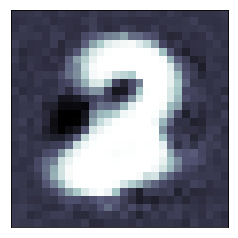

In [15]:
import numpy as np
y = model.decode(Variable(torch.Tensor(a)))
y = y.data.numpy()
y = np.reshape(y,(28,28))
plt.imshow(y,cmap='bone')
plt.xticks([])
plt.yticks([])
plt.show()

In [16]:
lambdas = np.linspace(0,1,64)

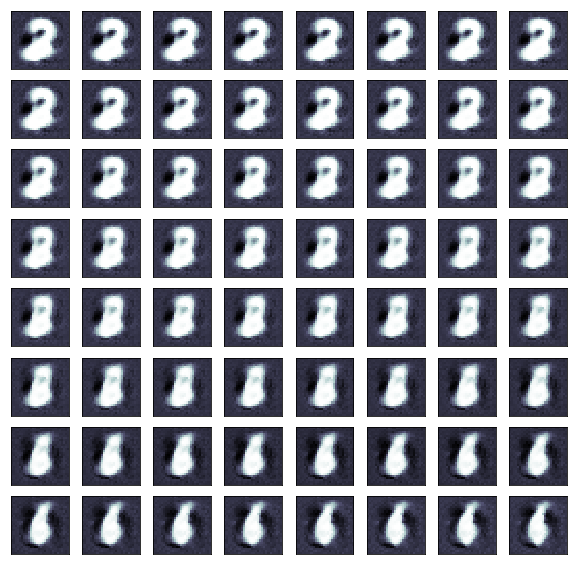

In [17]:
fig=plt.figure(figsize=(10,10))
for i,l in enumerate(lambdas):
    plt.subplot(8,8,i+1)
    code = torch.Tensor( (1 - lambdas[i])*a + lambdas[i]*b )
    y = model.decode(Variable(code))
    y = y.data.numpy()
    y = np.reshape(y,(28,28))
    plt.imshow(y,cmap='bone')
    plt.xticks([])
    plt.yticks([])
plt.show()

# Search through the BN sizes

In [22]:
num_epochs = 20
widths = list(range(3,20))

In [ ]:
Losses = []

for w in widths:
    
    print('Bottleneck layer width = {}'.format(w))
    
    model = autoencoder(width=w)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    Loss = []
    for epoch in range(num_epochs):
        for data in dataloader:
            img, _ = data
            img = img.view(img.size(0), -1)
            img = Variable(img)

            output = model(img)
            loss = criterion(output, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        Loss.append(loss.item())
        print('epoch [{}/{}], loss:{:.4f}'
              .format(epoch + 1, num_epochs, loss.item()))
        if epoch % 10 == 0:
            pic = to_img(output.data)
            save_image(pic, './simple_autoencoder/image_{}_width_{}.png'.format(epoch,w))
    
    Losses.append(Loss)
    torch.save(model.state_dict(), './simple_autoencoder/simple_autoencoder_' + str(w) + '.pt')

In [ ]:
np.save('./simple_autoencoder/Losses', Losses)

In [20]:
Losses = np.load('./simple_autoencoder/Losses.npy')

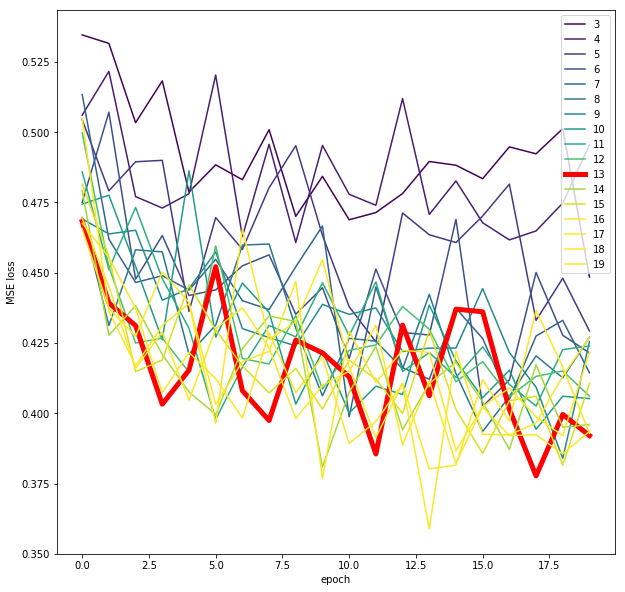

In [23]:
cmap = plt.cm.viridis
step = 20
fig=plt.figure(figsize=(10,10))
for i,w in enumerate(widths):
    if w==13:
        plt.plot(Losses[i], 'r', label=w, linewidth=5)
    else:
        plt.plot(Losses[i], color=cmap(i*step), label=w)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.show()

In [24]:
ms = np.mean(Losses[:,10:], axis=1)

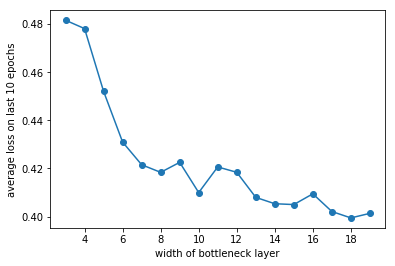

In [25]:
plt.plot(widths,ms,'-o')
plt.xlabel('width of bottleneck layer')
plt.ylabel('average loss on last 10 epochs')
plt.show()